In [35]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

from sklearn.externals import joblib
import pickle

In [2]:
df=pd.read_csv('restaurant_star_prediction_to_use.csv')

In [3]:
restaurant_list=['business_id','name']
location_feature=['state','neighborhood']
restaurant_attribute_feature_numerical=['BikeParking','Caters','GoodForKids','HasTV','OutdoorSeating','RestaurantsDelivery','RestaurantsGoodForGroups',
                                       'RestaurantsPriceRange2','RestaurantsReservations','RestaurantsTableService']
restaurant_attribute_feature_categorical=['attribute']
restaurant_feature_cat=['categories_clean_short']
user_feature=['review_text']
target=['label']

In [4]:
X_base_location_only=pd.get_dummies(df[location_feature],drop_first=True)
y=df[target]

In [5]:
X_num_attr=df[restaurant_attribute_feature_numerical].fillna(0)

In [6]:
X_2=pd.concat([X_base_location_only,X_num_attr],axis=1)

In [7]:
cv=CountVectorizer(stop_words='english',ngram_range=(1,1))

In [8]:
vect=cv.fit_transform(df[restaurant_attribute_feature_categorical]['attribute'])

In [9]:
df_cat_attr=pd.DataFrame(vect.toarray(),columns=cv.get_feature_names())

In [10]:
X_3=pd.concat([X_2,df_cat_attr],axis=1)

In [11]:
df_cat_clean_short=df[restaurant_feature_cat]
df[restaurant_feature_cat]=df[restaurant_feature_cat].astype('str')

In [12]:
cv_cat_clean_short=CountVectorizer(stop_words='english',ngram_range=(1,1))
vect_cat_clean_short=cv_cat_clean_short.fit_transform(df[restaurant_feature_cat]['categories_clean_short'])
df_cat_attr_clean_short=pd.DataFrame(vect_cat_clean_short.toarray(),columns=cv_cat_clean_short.get_feature_names())

In [13]:
X_3_1=pd.concat([X_3,df_cat_attr_clean_short],axis=1)

In [14]:
df_user_review=df[user_feature]

In [15]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [16]:
df_user_review=standardize_text(df_user_review,'review_text')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [17]:
cv_user_review_tfidf_best=TfidfVectorizer(stop_words='english',ngram_range=(1,1),max_features=500)
vect_user_review_tfidf_best=cv_user_review_tfidf_best.fit_transform(df_user_review['review_text'])
df_user_review_tfidf_best=pd.DataFrame(vect_user_review_tfidf_best.toarray(),columns=cv_user_review_tfidf_best.get_feature_names())
X_3_1_best=pd.concat([X_3_1,df_user_review_tfidf_best],axis=1)
X_3_1_best_train,X_3_1_best_test,y_train,y_test=train_test_split(X_3_1_best,y,test_size=0.2,random_state=5)
clf_3_1_best = LogisticRegression()
clf_3_1_best.fit(X_3_1_best_train,y_train)
clf_3_1_best_predict=clf_3_1_best.predict(X_3_1_best_test)
df_clf_3_1_best=pd.DataFrame()
df_clf_3_1_best['diff']=np.abs(clf_3_1_best_predict-y_test.values.ravel())
print(df_clf_3_1_best['diff'].value_counts())
print(df_clf_3_1_best['diff'].sum()/len(df_clf_3_1_best['diff']))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0    3087
1    2546
2     354
3      42
4       7
Name: diff, dtype: int64
0.5646123260437376


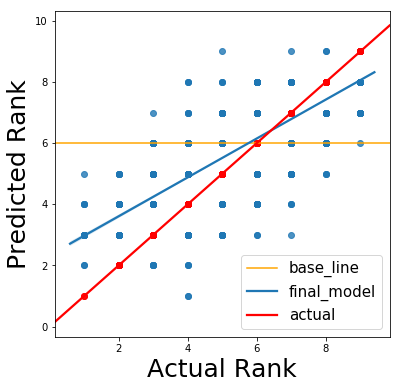

In [34]:
plt.figure(figsize=(6,6))
#sns.regplot(y_test.values.ravel(),clf_predict)
plt.axhline(y=y_test.values.ravel().mean(), color='orange', linestyle='-')
sns.regplot(y_test.values.ravel(),clf_3_1_best_predict)
sns.regplot(clf_3_1_best_predict,clf_3_1_best_predict,color='r')
plt.xlabel('Actual Rank',fontsize=25)
plt.ylabel('Predicted Rank',fontsize=25)
plt.legend(['base_line','final_model','actual'],fontsize=15,loc=0)

In [19]:
with open('restaurant_rating_avg_X.pkl','wb') as file:
    pickle.dump(X_3_1_best,file)

In [20]:
with open('restaurant_rating_avg_X.pkl','rb') as file:
    testing=pickle.load(file)

In [ ]:
./restaurant_rating_avg_to_display.pkl

In [38]:
with open('restaurant_rating_avg_X.pkl','rb') as file:
    testing=pickle.load(file)

In [39]:
testing

,state_AZ,state_NC,state_NV,state_OH,state_ON,state_PA,state_QC,state_WI,neighborhood_Ahuntsic-Cartierville,neighborhood_Alexandra Park,...,worst,worth,wouldn,wow,wrong,year,years,yelp,yes,yummy
0,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,0,0,0,0,0,0,0,0,...,0.020018,0.000000,0.000000,0.000000,0.000000,0.010360,0.017970,0.010196,0.000000,0.019791
3,0,0,0,0,1,0,0,0,0,0,...,0.008211,0.022494,0.005223,0.020779,0.009803,0.016999,0.051597,0.008365,0.010707,0.021649
4,1,0,0,0,0,0,0,0,0,0,...,0.002668,0.033988,0.005092,0.010128,0.007167,0.013809,0.021556,0.012231,0.003914,0.021104
5,0,0,0,0,0,0,0,1,0,0,...,0.004815,0.017807,0.004595,0.010444,0.008623,0.014953,0.015129,0.009810,0.021191,0.004761
6,0,0,1,0,0,0,0,0,0,0,...,0.045146,0.000000,0.000000,0.000000,0.000000,0.046730,0.081052,0.000000,0.000000,0.000000
7,0,0,1,0,0,0,0,0,0,0,...,0.008624,0.024807,0.012344,0.011692,0.015444,0.004464,0.058064,0.021964,0.008435,0.029844
8,0,0,0,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0,0,0,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.258102,0.000000,0.000000,0.000000


In [ ]:
with open('restaurant_rating_avg_X.pkl','rb') as file:
    testing=pickle.load(file)

In [21]:
joblib.dump(clf_3_1_best,'restaurant_rating_avg_prediction_model.pkl')

['restaurant_rating_avg_prediction_model.pkl']

In [22]:
model=joblib.load('restaurant_rating_avg_prediction_model.pkl')

In [23]:
model.predict(testing)

array([9, 7, 4, ..., 8, 6, 7], dtype=int64)

In [24]:
df_test=pd.DataFrame()

In [25]:
df_test['diff']=np.abs(df.label-model.predict(testing))

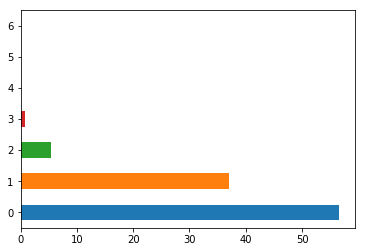

In [26]:
((df_test['diff'].value_counts()/len(df_test['diff']))*100).plot(kind='barh')

In [27]:
#df_display=df[['address','categories','state','city','categories_clean_short','label']].copy()

In [28]:
#df_display.columns=['address','categories','state','city','categories_clean','rating']

In [29]:
#with open('restaurant_rating_avg_to_display.pkl','wb') as file:
    #pickle.dump(df_display,file)

In [66]:
#with open('restaurant_rating_avg_to_display.pkl','rb') as file:
    #testing2=pickle.load(file)